Author: Muhammad Ammad-ud-din

Place: Helsinki, Finland

Classification is a machine learning problem where the goal is to learn a discriminative model (function and its parameters) in a supervised setting: Given a set of samples having multi-dimensional features, for which outcome measurements exist, predict the outcome for a new sample. The development of robust and efficient predictve techniques is a two-fold data science approach: (1) data exploration, (2) machine learning model selection and evaluation.

As a first step, exploratory analysis of the data is essential to gain insights into the problem as well as into the data and to identify the underlying modeling challenges. Moreover, data exploration also helps to formulate the appropriate modeling assumptions and experimental design while considering the resources at hand. As a second step, selection of the optimal model is crucial such that it generalizes to the new data. The optimal model can be selected based on the performance metric obtained through rigorous evaluation of the modeling assumptions with a principled experimental design.

In [55]:
import numpy as np
import pandas as pd
import copy
import tensorflow as tf

from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randuni
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

import pickle as cpickle

%matplotlib inline
import requests, json

from flask import Flask, abort, jsonify, request
RANDOM_STATE = 1707

In [2]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [3]:
try:
    xTrain = pd.read_csv("x_train.csv", header=None,na_values=[' '])
    xTest = pd.read_csv("x_test.csv", header=None,na_values=[' '])
    yTrain = pd.read_csv("y_train.csv", header=None,na_values=[' '])
except:
    print("Dataset could not be loaded. Is the dataset missing?")

In [4]:
xTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0.606214,0.885170,0.827193,0.197169,0.560501,0.890003,1.183692,0.531270,1.010373,1.462041,...,1.499250,2.113217,1.447677,2.379565,1.806187,1.696898,0.662901,0.632434,7.619987,1f74519b-b170-4aa2-8976-0ccb30ead4a8
1,0.960236,0.761134,0.981690,0.460387,0.556353,0.841962,0.807776,0.408703,0.322817,2.292254,...,1.155194,0.408494,1.141338,3.194768,1.964883,0.473063,0.689351,0.618515,0.918748,b3864e3b-3fad-41b5-aaa1-bc5866bfc1e5
2,0.666303,0.791899,0.741582,0.203568,0.561863,0.865028,1.127813,0.636855,0.186862,0.688134,...,0.745066,0.371322,1.549863,2.834910,0.513000,0.691359,0.669160,0.609175,0.900033,fcd7a7d6-526f-4395-8906-e8cf9c901b96
3,0.344948,0.835305,0.874043,0.264302,0.564776,0.876306,0.226912,0.371902,0.408772,0.947090,...,1.260049,4.605839,0.569633,1.003212,0.700921,0.640504,0.719134,0.640261,3.250265,4c4b4768-1814-46dc-98a0-1af6aacfa727
4,1.753590,0.895283,0.561427,0.977942,0.564281,0.854353,0.220271,0.724181,1.255830,0.408187,...,1.019089,2.369277,0.620066,0.431046,0.381634,1.036588,0.680336,0.609462,0.109194,4e61ac09-3426-4604-bf0c-4a03b3da43ac


In [5]:
xTest.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0.466986,0.940068,0.936647,1.916596,0.566261,0.845571,0.101800,0.327037,0.897099,1.312454,...,0.996853,1.035089,0.609449,0.058837,0.676833,0.482639,0.667861,0.636093,0.763367,c25ee611-c243-4808-84fc-c2abc579c0b0
1,0.728934,0.913009,0.702597,0.885783,0.565379,0.864201,0.336945,0.909036,3.366125,1.167272,...,1.133631,1.268683,1.007631,0.742551,0.673346,0.929803,0.802681,0.624777,0.333647,3a5f258c-5a37-4208-9eb6-acdf6942e13f
2,0.977341,0.807194,0.598666,0.289551,0.568274,0.847702,1.055096,0.612615,1.259868,0.136373,...,1.081810,0.280314,1.421475,2.281617,0.413037,0.583962,0.660914,0.619148,0.470799,23c7989a-249b-4498-afa3-dd02c5ea1a15
3,0.225681,0.900849,0.851252,0.123085,0.561047,0.938914,0.353739,0.441253,0.553648,0.225964,...,0.879359,1.052568,1.828610,0.746832,0.929029,0.888206,0.644901,0.637947,0.461205,134866d9-e72e-4b76-abc1-6f6347c4b2af
4,0.411694,0.727791,0.805261,0.292094,0.561952,0.926761,0.556427,0.482158,0.592753,0.523023,...,1.354237,1.208800,0.356954,0.928384,3.617595,1.053306,0.663670,0.626969,1.038405,09bd3970-3745-4074-bc68-2f656e49c6cb


In [6]:
yTrain.head()

,0,1
0,1f74519b-b170-4aa2-8976-0ccb30ead4a8,3
1,b3864e3b-3fad-41b5-aaa1-bc5866bfc1e5,1
2,fcd7a7d6-526f-4395-8906-e8cf9c901b96,3
3,4c4b4768-1814-46dc-98a0-1af6aacfa727,4
4,4e61ac09-3426-4604-bf0c-4a03b3da43ac,3


In [7]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)

(1200, 1001)
(1200, 2)
(4800, 1001)


In [9]:
trainingUserIds = xTrain.iloc[:,-1]
#print(trainingUserIds)
testUserIds = xTest.iloc[:,[-1]]
#print(testUserIds)
#xTrain.set_index(['1000'], inplace=True)
#xTrain.head(5)

In [10]:
xTrain = xTrain[xTrain.columns[0:1000]]
xTest = xTest[xTest.columns[0:1000]]

print(xTrain.shape)
print(xTest.shape)

(1200, 1000)
(4800, 1000)


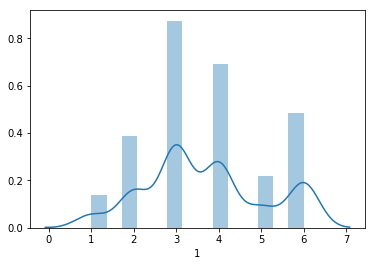

In [11]:
sns.distplot(yTrain.iloc[:,1])

In [12]:
xTrain = np.array(xTrain)
xTest = np.array(xTest)


In [13]:
stdFeatures = np.std(xTrain, axis = 0)


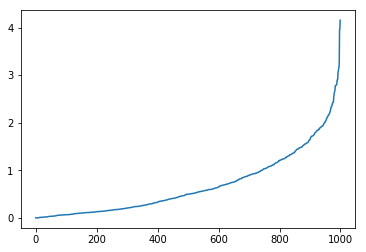

In [14]:
sns.lineplot(range(1000),np.sort(stdFeatures))

In [15]:
nFeatures = 200
index = stdFeatures.argsort()[-nFeatures:][::-1]

In [ ]:
#stdFeatures[index]

In [19]:
xTrain_norm = copy.deepcopy(xTrain[:,index]) #[:,index]
xTest_norm = copy.deepcopy(xTest[:,index]) #[:,index]
meanXtrain = np.mean(xTrain_norm,axis=0)
stdXtrain = np.std(xTrain_norm,axis=0)

xTrain_norm = (xTrain_norm-meanXtrain)/stdXtrain
xTest_norm = (xTest_norm-meanXtrain)/stdXtrain



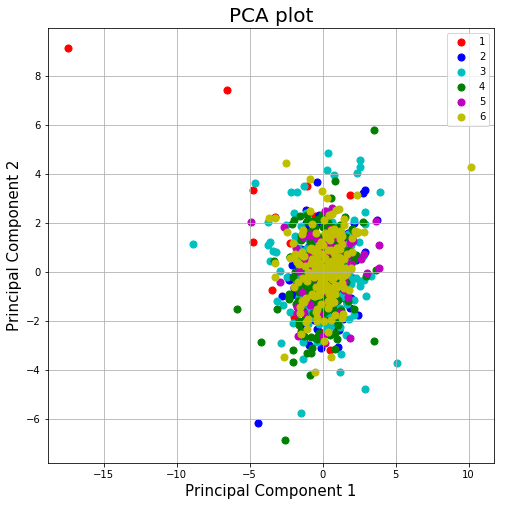

In [20]:
pca = PCA(n_components = 2)
pca.fit(xTrain_norm)
xPCA = pca.transform(xTrain_norm)

principalDf = pd.DataFrame(data = xPCA
            , columns = ['principal component 1', 'principal component 2'])
target = pd.DataFrame(yTrain.iloc[:,1])
#print(target)
finalDf = pd.concat([principalDf, target], axis = 1)
finalDf.rename(columns={1: 'target'}, inplace=True)
#print('PCA plot before correcting for technical variation (noise) i.e., device specific')


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA plot', fontsize = 20)
targets = [1, 2, 3, 4, 5, 6]
colors = ['r', 'b', 'c', 'g', 'm', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#encoder = LabelEncoder()
#encoder.fit(yTrain.iloc[:,1])
#encoded_Y = encoder.transform(yTrain.iloc[:,1])
# convert integers to dummy variables (i.e. one hot encoded)
#encoded_Y

In [22]:
dummy_y = pd.get_dummies(yTrain.iloc[:,1])#np_utils.to_categorical(encoded_Y)
#dummy_y

In [23]:
dummy_y = np.array(dummy_y)
#dummy_y

In [24]:
xTrain_norm.shape

(1200, 200)

In [25]:
dummy_y.shape

(1200, 6)

In [ ]:
#pca = KernelPCA(n_components = 10)
#pca.fit(xTrain_norm)
#xPCA = pca.transform(xTrain_norm)
#xPCA_test = pca.transform(xTest_norm)

###The solution(?):
Since my knowledge about the given problem was limited, therefore it was difficult to formulate the correct assumptions to model non-linear or complex relationships. I, therefore, compared various machine learning models and chose the model that provided best classification performance and is better generalizable. To put into context, I evaluated Random Forest (RF), Logistic Regression (LR) and a state-of-the-art non-parameteric K-Nearest Neighbor (KNN) models on the task of classifying new samples into two classes.

As a model selection procedure, I performed 10-fold cross-validation (CV) on the training data, wherein each fold of the CV run, 1/10th of the data was used as a validation set at random, while the model was trained on the other 9/10 data. Since each model has specific parameters to be tuned (aka Hyperparameters), a nested Randomized CV approach was adopted for that purpose.

And, for each modeling approach, predictive performances were avraged across the validation set predictions obtained from a each round of CV experiment. Mainly, the accuracy and hamming loss performance metric are used to evaluate the efficient model.

In simple words, training data was used to tune the hyperparameters and validation data was utilized to assess the predictive performance and to select the best model. The test set predictions were generated using the best model.

###Hyperparameter Tuning and Model Selection:
In a machine learning model, hyperparameters represents the our prior beliefs about the model structure and the underlying data generation process. Since we have little knowledge about the real-world process and the degree of noise that has corrupted the data, it is difficult to fix suitable hyperparameters apriori. We have to resort to optimization methods to supplement our beliefs on the potentially appropriate choices of the hyperparameters. The performance and generalisation properties of model is very dependent on values chosen for the hyper-parameters. As the number of hyper-parameters and the number of values they can have increases the more complex the hyper-parameter optimisation problem becomes.

Grid Search, a typical approach to hyper-parameter tuning is to build the ML model in question, over all the data for different combination of hyper-parameters. So for 2 hyper-parameters, the first with 3 possible values and the second with 5 then a total of 15 models would need to be built and tested to find the optimal hyper-parameter configuration. If each hyper-parameter had 10 possible values then 100 comparisons would be required. It is easily seen the number of possible hyper-parameter configurations increases exponentially with the number of hyper-parameters and the number of values they can have.

On the contrary, a randomised search approach to hyper-parameter tuning is known to be more efficient than a grid-search in terms of computational time. Randomised search means searches are not wasted on parts of the hyper-parameter grid which have little influence on the performance of the model based on the low effective dimension of the hyper-parameter space. Thus, I chose RandomizedSearchCV as a hyperparamter tuning and model selection procedure.

In [33]:
#define hyperparamters and CV configurations
nFolds = 10
randomIterations = 10
cv = KFold(n_splits=nFolds)


param_grid = {#'SVC':{"C": sp_randint(1, 1e5),
              #       "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1,0.5,1.0],
              #       "kernel": ['rbf']},
              
             'KNN':{"n_neighbors":sp_randint(2, 10),
                   "algorithm":["ball_tree","kd_tree","brute","auto"],
                   "p":[1,2]},
            'LR':{"l1_ratio": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
             #'GB': {"loss":["deviance","exponential"],
             #       "n_estimators": sp_randint(100, 500),
             #       "max_depth": sp_randint(3, 15),
             #       "max_features": ["auto","sqrt","log2",None],
             #       "min_samples_split": sp_randint(2, 3),
             #       "min_samples_leaf": sp_randint(2, 3),
             #       "learning_rate":[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5]}
            'RF': {"n_estimators": sp_randint(100, 150),
                     "max_depth": sp_randint(3, 10),
                     "max_features": sp_randint(2, 3),
                     "min_samples_split": sp_randint(2, 3),
                     "min_samples_leaf": sp_randint(1, 3)},
             }

#set RandomizedCV approach for the model selection and hyperparameter tuning
classifiers = ['KNN', RandomizedSearchCV(KNeighborsClassifier(weights='distance'), 
                                        param_distributions=param_grid['KNN'],n_iter=randomIterations,cv=nFolds,scoring='accuracy'),
               'LR', RandomizedSearchCV(LogisticRegression(penalty='elasticnet',fit_intercept=False,multi_class='multinomial'), 
                                        param_distributions=param_grid['LR'],n_iter=randomIterations,cv=nFolds,scoring='accuracy')]
            #'RF', RandomizedSearchCV(estimator=RandomForestClassifier(class_weight="balanced_subsample", oob_score=True,random_state=RANDOM_STATE), 
            #                            param_distributions=param_grid['RF'],n_iter=randomIterations,cv=nFolds,scoring='balanced_accuracy')]
    
    
               #'GB', RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=RANDOM_STATE), 
               #                         param_distributions=param_grid['GB'],n_iter=randomIterations,cv=nFolds,scoring='roc_auc'),
               #'SVC', RandomizedSearchCV(SVC(probability=True,random_state=RANDOM_STATE,class_weight='balanced'), #class_weight='balanced',
               #                         param_distributions=param_grid['SVC'],n_iter=randomIterations,cv=nFolds,scoring='roc_auc'),
                                     


#make model evaluation pipelines
pipelines = [
    ['{}'.format(classifiers[0]),
     classifiers[1]], #RF
    #['{}'.format(classifiers[2]),
    # classifiers[3]], #GB
    #['{}'.format(classifiers[4]), 
    # classifiers[5]], #SVC
    ['{}'.format(classifiers[1]), classifiers[1]] #KNN
    #['{}'.format(classifiers[2]), classifiers[1]]
]

In [34]:
for name, pipeline in pipelines:
    print("{Model}", name)
    accuracy = 0.0
    hLoss = 0.0
    
    for train, test in cv.split(xTrain_norm, dummy_y):
        yPred = pipeline.fit(xTrain_norm[train], dummy_y[train]).predict(xTrain_norm[test])
        accuracy += accuracy_score(dummy_y[test], yPred, normalize=True, sample_weight=None)
        hLoss += hamming_score(dummy_y[test], yPred)
        
    accuracy /= nFolds
    hLoss /= nFolds

    print('Accuracy: {0}'.format(accuracy))
    print('Hamming score: {0}'.format(hLoss))
    


{Model} KNN
Accuracy: 0.22999999999999998
Hamming score: 0.22999999999999998
{Model} RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a31898a58>, 'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'], 'p': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)
Accuracy: 0.22916666666666666
Hamming score: 0.22916666666666666


### Model selction for production
As seen from the CV results that both KNN and LR (regularized version) gave very similar performances, I choose KNN to run in production. Mainly, because KNN is a non parametric model and requires less resources compared to LR. In LR the number of parameters is eqivalent to the number of features and thus require more fine-tunning as compared to the KNN model.  

In [44]:
name= pipelines[0][0] 
pipeline = pipelines[0][1]


print("{{Model} : ", name)


model = pipeline.fit(xTrain_norm, dummy_y)
yPred = model.predict(xTest_norm)



{{Model} :  KNN


In [45]:
yPred = pd.DataFrame(yPred, columns=['1','2','3','4','5','6'])


In [49]:
predictions = copy.deepcopy(yPred)

In [50]:

predictions = pd.DataFrame(predictions.columns[np.where(yPred!=0)[1]])
testUserIds = pd.DataFrame(testUserIds)

predictions = pd.concat([testUserIds,predictions],axis=1)

predictions.columns = ['user_id','class']

In [105]:
#predictions

In [52]:
predictions.to_csv('predictions.csv')

In [53]:
cpickle.dump(predictions, open("predictions.pkl", "wb"))


### To run the API
 a- open the terminal and write: python operationlize_sanome_project.py 
### To get the predictions from API
 b- Run the snippet on the terminal or inside the jupyter notebook.


In [104]:
url = "http://localhost:9000/predictions"
data = json.dumps({'user_id':'c25ee611-c243-4808-84fc-c2abc579c0b0'}) 
r = requests.post(url, data)

print(r.json())

{'class': 3}



### Answer to the questions

1) What were the most important technical decisions and on what grounds did
   you make them?
   
        a- Reducing the dimensionality by choosing the features which have high variance/std.
        b- Testing the models which have relatvely low cost (computation time)
        c- Model complexity selection using the Randomize Cross Validation as Grid Search is more expensive
        d- PCA analysis shows that there are inhereent non-linearities , a model that can capture non-linear relationships would be better choice. 
   
2) How would you communicate prediction quality to a business stakeholder?
   Assume limited knowledge of statistics or machine learning on their part.
   
           a. In a stratified KFold settings, a random baseline would have given a 100/6 = 16.6% accuracy (since there are 6 labels). A machine learning model yielding an average 23% accuracy indicates that the predictions would be 7% more accurate compare to when no machine learning model is used. 
   
3) If time and/or interest had permitted, how would you have improved on your
   solution?

       a. Further data exploration to understand more about the data
       b. Stratified KFold to choose the hyperparameter (as some classes have very small number of labels)
       c. Further exploring the dimensionality reduction approaches. 
       d. Evaluation metrics that take into account the multi-label predictions (e.g., balance accuracy)

